In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import torch
from torch import nn
from torch.utils.data import DataLoader

In [2]:
import model_demo

In [7]:
a=model_demo.main()

Using mps device
Shape of known_freqs tensor: torch.Size([10000, 3937])
Shape of snv_freqs tensor: torch.Size([10000, 6520])
Training set size: 8000
Validation set size: 1000
Test set size: 1000
Known frequencies batch shape: torch.Size([1000, 3937])
SNV frequencies batch shape: torch.Size([1000, 6520])
First batch - SNV frequencies: tensor([[0.0000, 0.0000, 0.1154,  ..., 0.0000, 0.4039, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2641, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4486, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0928, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6767, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2755, 0.0000]],
       device='mps:0')
First batch - Known frequencies: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1154],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
     

In [9]:
print (a)

None


In [2]:
import torch
from torch import nn, optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import sys

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size

        # Calculate the step size for linear scaling
        step_size = (output_size - input_size) / (num_hidden_layers + 1)

        for i in range(num_hidden_layers):
            out_features = int(in_features + step_size)
            linear_layer = nn.Linear(in_features, out_features)
            layers.append(linear_layer)

            # Batch normalization
            layers.append(nn.BatchNorm1d(out_features))

            # activation
            layers.append(nn.ReLU())
            in_features = out_features

        # Output layer
        layers.append(nn.Linear(in_features, output_size))
        #layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Now the model directly returns the probabilities
        return self.model(x)

class DeconvolutionModel:
    def __init__(self, input_size, output_size, num_hidden_layers, device=None):
        self.device = device or (
            "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        )
        print(f"Using {self.device} device")
        self.model = MLP(input_size, output_size, num_hidden_layers).to(self.device)
        self.loss_fn = nn.MSELoss()
        #self.loss_fn = WeightedErrorLoss() # example custom loss
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        self.train_losses = []
        self.val_losses = []

    def fit(self, train_dataloader, val_dataloader, epochs=1, patience=100):
        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            for batch, (X, y) in enumerate(train_dataloader):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction and loss
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_dataloader)
            self.train_losses.append(avg_train_loss)
            
            # Validation phase
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for X, y in val_dataloader:
                    X, y = X.to(self.device), y.to(self.device)
                    pred = self.model(X)
                    loss = self.loss_fn(pred, y)
                    val_loss += loss.item()
            
            avg_val_loss = val_loss / len(val_dataloader)
            self.val_losses.append(avg_val_loss)

            print(f"Epoch {epoch+1}, Train loss: {avg_train_loss:>7f}, Validation loss: {avg_val_loss:>7f}")

            # Early stopping if model fails to improve
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                best_model_wts = self.model.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f'Early stopping on epoch {epoch+1}')
                    self.model.load_state_dict(best_model_wts)
                    break

    def evaluate(self, dataloader):
        self.model.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss = 0

        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                test_loss += self.loss_fn(pred, y).item()

        test_loss /= num_batches
        print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

    def predict(self, dataloader):
        self.model.eval()
        predictions = []
        actuals = []

        with torch.no_grad():
            for batch in dataloader:
                X, y = batch
                X = X.to(self.device)
                pred = self.model(X)
                predictions.append(pred.cpu().numpy())
                actuals.append(y.cpu().numpy())

        return np.concatenate(predictions), np.concatenate(actuals)

In [8]:
def main():
    # Use hardware accelerator if available
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")

    # TODO: Change so dataframe passed directly
    # This way we can subset it in this script for faster training during development
    n = 10000
    known_freqs_file = f'known_freqs_{n}.npy'
    snv_freqs_file = f'snv_freqs_{n}.npy'

    # If training data exists just read from file
    # TODO: Can add a --force argument later
    if os.path.exists(known_freqs_file) and os.path.exists(snv_freqs_file):
        # Load data from files
        known_freqs = torch.tensor(np.load(known_freqs_file), dtype=torch.float32)
        snv_freqs = torch.tensor(np.load(snv_freqs_file), dtype=torch.float32)
    else:
        # Generate training examples if files do not exist
        known_freqs, snv_freqs = generate_training_examples('data/usher_barcodes.csv', n)
        
        # Save generated data to files
        np.save(known_freqs_file, known_freqs.numpy())
        np.save(snv_freqs_file, snv_freqs.numpy())

    # Move tensors to the selected device
    known_freqs = known_freqs.to(device)
    snv_freqs = snv_freqs.to(device)
    dataset = TensorDataset(snv_freqs, known_freqs)  # x,y

    # Example: Print the shapes of the tensors
    print(f"Shape of known_freqs tensor: {known_freqs.shape}")
    print(f"Shape of snv_freqs tensor: {snv_freqs.shape}")

    # TODO: CLI arguments to set the split
    total_size = len(dataset)
    test_size = total_size // 10  # 10% for test
    validation_size = total_size // 10  # 10% for validation
    train_size = total_size - test_size - validation_size  # 80% train

    # Split the dataset
    train_dataset, validation_dataset, test_dataset = random_split(
        dataset, [train_size, validation_size, test_size]
    )

    # verify sizes
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(validation_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # DataLoaders (makes training in batches easier)
    batch_size = 1000  # Arbitrarily chosen
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print first batch for validation
    for batch in train_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"First batch - SNV frequencies: {snv_freqs_batch}")
        print(f"First batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"First batch - Known frequencies (non-zero) {i}: {non_zero_freq}\n")
            break
        print()
        break

    # Print the first batch of the validation_loader
    for batch in validation_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Validation Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"Validation SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"Validation batch - SNV frequencies: {snv_freqs_batch}")
        print(f"Validation batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"Validation batch - Known frequencies (non-zero) {i}: {non_zero_freq}\n")
            break
        print()
        break

    # Print the first batch of the test_loader
    for batch in test_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Test Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"Test SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"Test batch - SNV frequencies: {snv_freqs_batch}")
        print(f"Test batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"Test batch - Known frequencies (non-zero) {i}: {non_zero_freq}")
            break
        print()
        break
    
    # Initialize the model (example input and output sizes)
    input_size = snv_freqs.shape[1]
    output_size = known_freqs.shape[1]
    num_hidden_layers = 1  # simplest model

    model = DeconvolutionModel(input_size, output_size, num_hidden_layers, device)

    # Train the model
    model.fit(train_loader, validation_loader, epochs=500)

    # Evaluate the model
    model.evaluate(validation_loader)

    # Predict using the model
    predictions, actuals = model.predict(test_loader)

    print(predictions)
    print(actuals)

    plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5);

    # Create a multi-page PDF file
    with PdfPages('training_validation_plots.pdf') as pdf:
        # Plot training and validation loss over epochs
        plt.figure(figsize=(10, 6))
        plt.plot(model.train_losses, label='Training Loss')
        plt.plot(model.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss Over Epochs')
        pdf.savefig()  # Save the current figure
        plt.close()

    with PdfPages('training_validation_plots.pdf') as pdf:
        # Plot predicted vs observed frequencies as a scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
        plt.xlabel('Predicted Frequencies')
        plt.ylabel('Actual Frequencies')
        plt.title('Predicted vs Actual Frequencies')
        pdf.savefig()  # Save the current figure
        plt.close()


Using mps device
Shape of known_freqs tensor: torch.Size([10000, 3937])
Shape of snv_freqs tensor: torch.Size([10000, 6520])
Training set size: 8000
Validation set size: 1000
Test set size: 1000
Known frequencies batch shape: torch.Size([1000, 3937])
SNV frequencies batch shape: torch.Size([1000, 6520])
First batch - SNV frequencies: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3344, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1786, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0286, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1510, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2686, 0.0000]],
       device='mps:0')
First batch - Known frequencies: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.

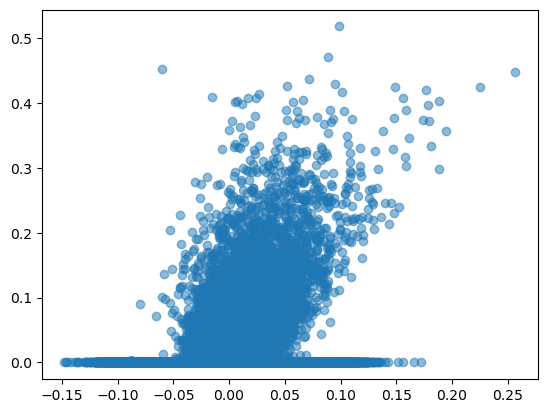

In [9]:
main()

In [19]:
print(predictions)

NameError: name 'predictions' is not defined